In [2]:
import pandas as pd
import os
import re
import json
import yaml
from glob import glob
from tqdm import tqdm
from pprint import pprint
import torch
from rouge import Rouge # 모델의 성능을 평가하기 위한 라이브러리입니다.

from torch.utils.data import Dataset , DataLoader
from transformers import AutoTokenizer, BartForConditionalGeneration, BartConfig
from transformers import Seq2SeqTrainingArguments, Seq2SeqTrainer
from transformers import Trainer, TrainingArguments
from transformers import EarlyStoppingCallback

import wandb # 모델 학습 과정을 손쉽게 Tracking하고, 시각화할 수 있는 라이브러리입니다.

In [5]:
data_path = "../../outputs/prediction/kobart_eval_output.csv"

df = pd.read_csv(data_path)

display(df.head())

display(df.describe())



,fname,dialogue,gold,pred,coverage_ratio,rouge-1,rouge-2,rouge-l,rouge_avg
0,dev_0,"#Person1#: 안녕하세요, 오늘 기분이 어떠세요?\n#Person2#: 요즘 ...",#Person2#는 숨쉬기 어려워합니다. 의사는 #Person2#에게 증상을 확인하...,#Person2# 는 감기에 걸렸지만 천식 검사를 위해 폐 전문의에게 가보라고 권...,0.647059,0.370370,0.320000,0.370370,0.353580
1,dev_1,"#Person1#: 야 Jimmy, 오늘 좀 이따 운동하러 가자.\n#Person2...",#Person1#는 Jimmy를 운동하러 초대하고 팔과 복근 운동을 하도록 설득합니다.,#Person1# 은 Jimmy에게 운동 날짜를 변경해 달라고 요청합니다. ...,0.692308,0.000000,0.000000,0.000000,0.000000
2,dev_2,#Person1#: 나 진짜 건강에 안 좋은 음식 좀 그만 먹어야겠어. \n#Per...,"#Person1#은 건강에 안 좋은 음식을 그만 먹기로 결심하고, #Person2#...",#Person1# 과 #Person2# 는 건강에 좋지 않은 음식을 줄이고 있다....,0.529412,0.160000,0.000000,0.160000,0.106667
3,dev_3,"#Person1#: 너 UFO 믿어?\n#Person2#: 당연하지, 있는 거 아냐...",#Person2#는 UFO를 믿고 꿈에서 볼 수 있다고 한다. #Person1#은 ...,#Person1# 은 #Person2# 에게 UFO가 지구에서 온 외계인이라고 설...,0.740741,0.000000,0.000000,0.000000,0.000000
4,dev_4,#Person1#: 오늘 학교 갔어?\n#Person2#: 당연히 갔지. 너는?\n...,"#Person1#은 오늘 학교에 가지 않았고, #Person2#는 내일 학교 대신 ...",#Person1# 은 #Person2# 에게 학교 대신 영화를 보러 가자고 제안합...,0.533333,0.173913,0.095238,0.173913,0.147688


,coverage_ratio,rouge-1,rouge-2,rouge-l,rouge_avg
count,499.000000,499.000000,499.000000,499.000000,499.000000
mean,0.616767,0.147185,0.050337,0.142531,0.113351
std,0.125351,0.116348,0.078750,0.113333,0.099282
min,0.250000,0.000000,0.000000,0.000000,0.000000
25%,0.533333,0.064516,0.000000,0.063508,0.043011
50%,0.615385,0.126984,0.000000,0.125000,0.088889
75%,0.707108,0.222222,0.086031,0.210526,0.168806
max,1.000000,0.727273,0.666667,0.727273,0.707071


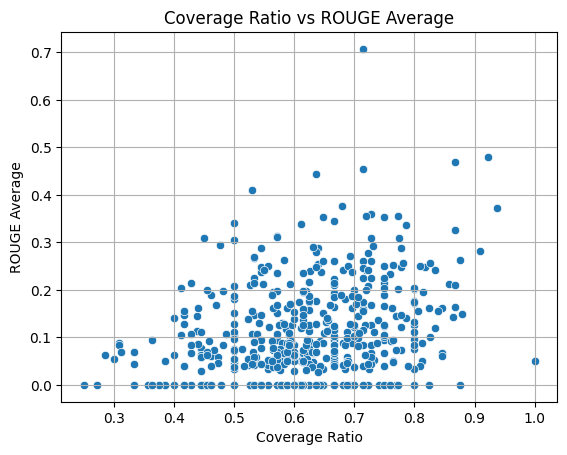

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

# 예시용 DataFrame 이름이 df라고 가정
sns.scatterplot(data=df, x="coverage_ratio", y="rouge_avg")
plt.title("Coverage Ratio vs ROUGE Average")
plt.xlabel("Coverage Ratio")
plt.ylabel("ROUGE Average")
plt.grid(True)
plt.show()

In [7]:
corr = df["coverage_ratio"].corr(df["rouge_avg"])
print(f"상관계수: {corr:.4f}")


상관계수: 0.3178


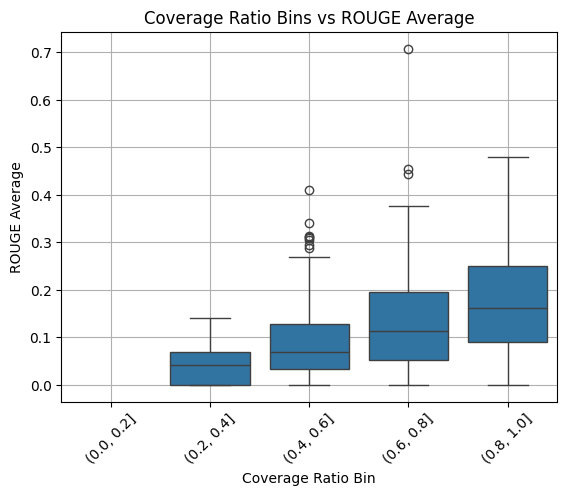

In [8]:
df["coverage_bin"] = pd.cut(df["coverage_ratio"], bins=[0, 0.2, 0.4, 0.6, 0.8, 1.0])

sns.boxplot(data=df, x="coverage_bin", y="rouge_avg")
plt.title("Coverage Ratio Bins vs ROUGE Average")
plt.xlabel("Coverage Ratio Bin")
plt.ylabel("ROUGE Average")
plt.xticks(rotation=45)
plt.grid(True)
plt.show()
